In [ ]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
class TSeries(TensorBase):pass

In [7]:
def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [8]:
# export
class TensorSeqs(TSeries):
    
    def show(self, ax = None, ctx=None, **kwargs):
        ctx = ifnone(ctx, ax)
        if ctx is None: _, ctx = plt.subplots(figsize=(5,5))
        array = np.array(self.cpu())
        arrays = no_emp_dim(array)
        m = self._meta.get('m',['b', 'c', 'm', 'y', 'k',][:len(arrays)])
        labels = self._meta.get('label',['x']*len(arrays))
        t = np.arange(array.shape[1])
        
        for a, c, label in zip(arrays, m, labels):            
            mark = '-' if 'y' not in label else ''                
            ctx.plot(t, a, mark + '*' +c, **kwargs, label=label)            #
        ctx.legend()
        return ctx
    

In [9]:
a = torch.cat([i+torch.arange(10)[None,:] for i in [0,2]])

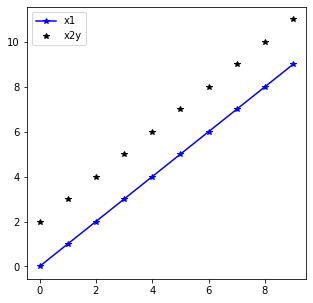

In [10]:
_, ctx = plt.subplots(figsize=[5,5])
ax = TensorSeqs(a, m=['b','k'], label = ['x1','x2y']).show(ctx=ctx)

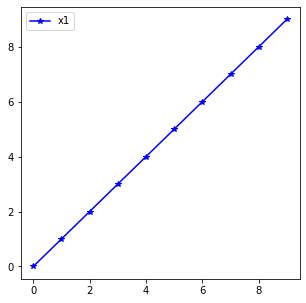

In [11]:
ax = TensorSeqs(torch.arange(10)[None,:], m=['b','k'], label = ['x1','x2']).show()

In [12]:
# export
class TensorCon(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','con')}: {str(self)}")
        return ax
    
class TensorCat(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','cat')}: {str(self)}")
        return ax

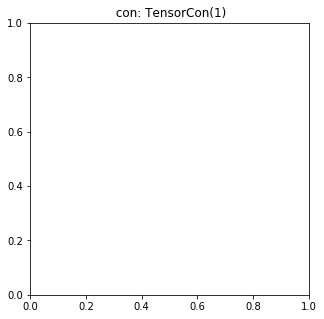

In [13]:
TensorCon(1).show()

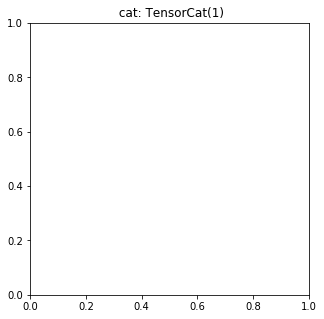

In [14]:
TensorCat(1).show()

## Utils

In [24]:
# export
from typing import List
def same_size_ts(ts:pd.Series, ts_names:List[str]):    
    all_same = [[(ts[c].shape == ts[a].shape) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)    
    return np.sum(mask) == len(ts_names)**2
    

In [25]:
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1']),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1']),False)

In [26]:
# export
def get_part_of_ts(x, lookback_id, length, pad=np.mean):
    if len(x.shape) == 1:
        x = x[None,:]
    if isinstance(x[0,0],int):
        x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = tensor(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        )).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = tensor(x[:,lookback_id:lookback_id + length]).float()
    return x


In [27]:
x = np.arange(10)
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
x = np.arange(10)[None,:]
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))
x = np.vstack([np.arange(10)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10)[None,:]
# test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# Dataloader

In [63]:
DataLoader.new??

Signature: DataLoader.new(self, dataset=None, cls=None, **kwargs)
Docstring: <no docstring>
Source:   
    def new(self, dataset=None, cls=None, **kwargs):
        if dataset is None: dataset = self.dataset
        if cls is None: cls = type(self)
        cur_kwargs = dict(dataset=dataset, num_workers=self.fake_l.num_workers, pin_memory=self.pin_memory, timeout=self.timeout,
                          bs=self.bs, shuffle=self.shuffle, drop_last=self.drop_last, indexed=self.indexed, device=self.device)
        for n in self._methods: cur_kwargs[n] = getattr(self, n)
        return cls(**merge(cur_kwargs, kwargs))
File:      ~/dev/env37/lib/python3.7/site-packages/fastai2/data/load.py
Type:      function


In [64]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1, min_seq_len=None, max_std= None, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                self.dataset[col] = pd.Series([pd.Series(o.flatten()) for o in self.dataset[col]])
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            elif isinstance(dataset[col].iloc[0], float):
                self.cat_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names
        self.ts_names.remove(y_name)
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []      

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res.make_ids()
        return res
    
    def check_std(self, r):  
        if self.max_std is not None:
            if (r[-1]/(r[0].std()+1e-7)).std() > self.max_std:
                if idx not in self.skipped:
                    self.skipped.append(idx)
                raise SkipItemException()
        
    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
        tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        r = [TensorSeqs(x, label=[self.y_name + '_x'], m=['g']), 
             TensorSeqs(tsx,label=self.ts_names)]
        if len(self.cat_names):
            r.append(TensorCon(row[self.cat_names].to_numpy().astype(float),label=self.cat_names))
        if len(self.con_names):
            # TODO make cat its own type
            r.append(TensorCon(row[self.con_names].to_numpy().astype(float),label=self.con_names))            
        # TODO make y its own type
        r.append(TensorSeqs(y, label=[self.y_name+ '_y'], m=['r']))
        return Tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx)
        self.check_std(r)              
        return r
    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [65]:
df = pd.DataFrame(data={'pred':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
df

,pred,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 1.816032 1 1.594705 2 1.072483 3 3.836508 4 4.285875 5 4.478235 6 6.158700 7 7.232298 8 7.668040 9 9.279565 dtype: float64,0.0,0
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 1.820998 1 1.776767 2 2.542567 3 3.726246 4 5.116781 5 6.733157 6 6.542469 7 7.366525 8 9.269712 9 10.072470 10 12.084283 11 12.069693 dtype: float64,1.0,1


In [66]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)


Need to pad 1/2 time series due to length.


In [67]:
for o in dl:
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'],o)}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['x'].shape,(3,1,9))
    break
dl.ts_names

{'x': torch.Size([3, 1, 9]), 'tsx': torch.Size([3, 2, 11]), 'cat': torch.Size([3, 1]), 'con': torch.Size([3, 1]), 'y': torch.Size([3, 1, 11])}


(#2) ['ts_0','ts_1']

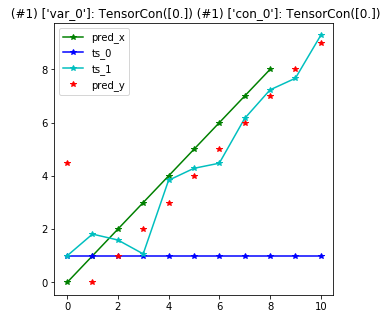

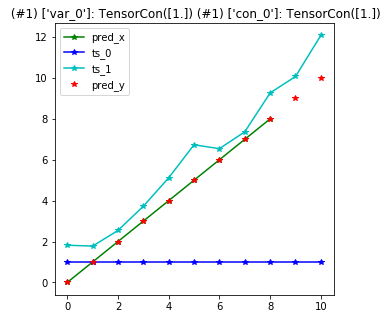

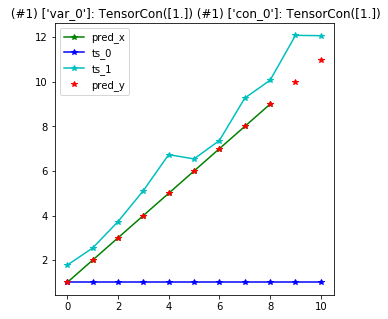

In [68]:
dl.show_batch(max_n=3)

In [69]:
# hide
# without cat or con
horizon,lookback = 2,9
dl = DfDataLoader(df[['pred','ts_0']], 'pred', horizon = horizon, lookback = lookback)


for o in dl:
    dct = {k:v for k,v in zip(['pred','ts_0','y'],o)}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['ts_0'].shape, dct['y'].shape)
    test_eq(dct['pred'].shape[1:],(1,9))
    break


Need to pad 1/2 time series due to length.
{'pred': torch.Size([3, 1, 9]), 'ts_0': torch.Size([3, 1, 11]), 'y': torch.Size([3, 1, 11])}


In [70]:
# hide
# test self.new
dl.new()

Need to pad 1/2 time series due to length.
Need to pad 1/2 time series due to length.


# Intergration Example

In [43]:
from fastseq.data.external import *

In [44]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df.head()

,x,weather,city,cont
0,"[[1.2782936985309832, 0.8548170535463527, 0.6177008405614915, 0.1652524887468404, 0.009094783838882138, -0.23875146172884743, -0.2393149322703259, 0.2745061680791437, 1.2309379115560863, 1.1494749639046173, 0.47966134478647005, -0.41039566118359966, -1.3242196125784875, -1.1854784709277615, -1.2171724883689286, -0.8110557609558727, -0.14323834410317832, 0.4833357117879322, 1.6185682102755599, 2.010522323732571, 1.8473338671816402, 1.0850577939968455, -0.164213490255283, -0.8771435651225985, -1.0527348696543313, -1.2333451947741247, -1.469192625377167, -1.4826489720664198, -1.03110812746013...","[[9.933420886281802, 9.525827884160222, 9.858218917351609, 10.679006872404639, 10.618860784114686, 9.260137463090961, 8.0740012898619, 8.682546286466179, 10.643236666978005, 11.793167124368384, 10.850421219536269, 8.934097261586928, 8.07268517121234, 8.732858118728181, 9.5730569328745, 9.508119732911132, 9.933420886281802, 9.525827884160222, 9.858218917351609, 10.679006872404639, 10.618860784114686, 9.260137463090961, 8.0740012898619, 8.682546286466179, 10.643236666978005, 11.793167124368384, 10.850421219536269, 8.934097261586928, 8.07268517121234, 8.732858118728181, 9.5730569328745, 9.508...",0,1.487612
1,"[[1.2032022325040517, 0.7109922270983826, 0.7050704692724773, 0.5321017840743035, 0.38744981633203646, 0.6225184937713693, 0.9301849463777772, 0.8559249826264408, 0.8311524543540232, 0.8211418861707571, 0.7901721227642899, 0.9971709585362575, 1.1979828204943532, 1.3358086785861705, 1.28429089414913, 0.9722488055153087, 0.6244114232368484, 0.34875447215575944, -0.2256383949254355, -0.7910211423736558, -0.7791865814419239, -0.922453892739079, -1.0630166414897115, -1.0287608750027484, -1.2731105301072667, -1.3479292521146224, -1.3368698639893233, -1.4354802609999413, -1.407016948624781, -1.04...","[[5.8776256425469695, 5.2240728361314135, 4.61133362872008, 4.52068661223563, 4.998120693572136, 5.620853619412445, 5.790109145023613, 5.154162025525722, 3.877069593859589, 2.5690383162112793, 1.9177731848795698, 2.2586831740468822, 3.363982209319046, 4.588334365832554, 5.275544270507262, 5.1606891843615825, 5.8776256425469695, 5.2240728361314135, 4.61133362872008, 4.52068661223563, 4.998120693572136, 5.620853619412445, 5.790109145023613, 5.154162025525722, 3.877069593859589, 2.5690383162112793, 1.9177731848795698, 2.2586831740468822, 3.363982209319046, 4.588334365832554, 5.275544270507262...",0,0.833290
2,"[[-1.2900070170481157, -1.7044781574944439, -1.473016777960125, -0.588029223685234, 0.435988673929744, 0.92906974030406, 1.264499689545307, 1.8676848267330683, 1.9203512553113877, 1.848647827189619, 0.6598089075835704, 0.1964054839474657, -0.11529347028832883, -0.2685194616389258, 0.2576745666295235, 0.004359987939534607, 0.9979121920011115, 1.0926110459023484, 0.945267152134259, 0.7822494891634825, 0.41869341933449866, -0.6291297210396565, -1.2680050445875273, -1.054642761149031, -0.6043616595256728, -0.8449058327206428, -0.738827757611986, -0.6815240450600024, -0.5709571843664931, -0.130...","[[0.6895046085277146, 0.3570371912817276, 1.5345764894391758, 3.3187643755048017, 3.9761947859056317, 3.207367423373253, 2.450340837895055, 2.8235092100788544, 3.5625974530106594, 3.1149067258475376, 1.3720222157162496, -0.059574197544596696, 0.05515091817092488, 0.9966096628754649, 1.1771114974913117, 0.3796214082633482, 0.6895046085277146, 0.3570371912817276, 1.5345764894391758, 3.3187643755048017, 3.9761947859056317, 3.207367423373253, 2.450340837895055, 2.8235092100788544, 3.5625974530106594, 3.1149067258475376, 1.3720222157162496, -0.059574197544596696, 0.05515091817092488, 0.99660966...",0,-0.589955
3,"[[-1.4941248052691776, -1.6682436590211627, -1.3714381657275612, -1.108648594144458, -0.5620804073055673, -0.15282314415582218, 0.026784309834850736, -0.016490064360495386, -0.29068285513823783, -0.8684996759402916, -1.0572452523429723, -1.4381700039082295, -1.296670363056319, -1.0517370414919371, -0.7726464777478717, -0.2

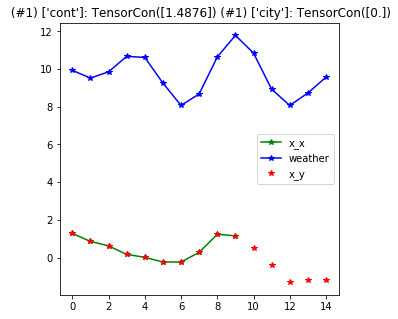

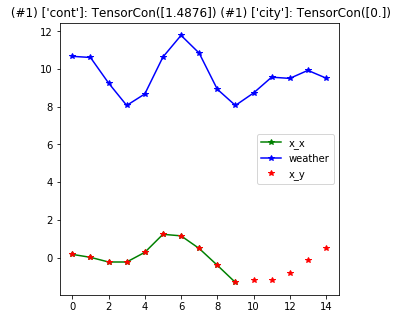

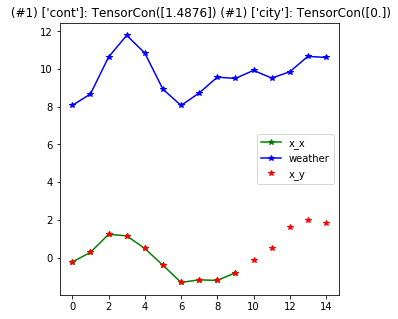

In [45]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3)
dl.show_batch(max_n=3)

In [71]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_data.core_pd.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
